Demonstration of learning difficulties in PyTorch

* A deep feedforward network vs. a deep highway network
* A recurrent network vs. a LSTM network




## Vanilla CNN vs. CNN + Residual Connection

Convolutional neural networks (CNNs) are usually used for computer vision tasks where you want to predict the object in an input image. 

As shown in below, we refer to CNNs of stacking modules of convolutional layer, pooling layer and activation function as **Vanilla CNNs**. The scale of the network can grow by its depth and width.

**Motivating question:** if we want to train a very deep, vanilla (no fancy designs), neural network (say 1000 layers) with SGD, do you anticipate problems? Will the training loss converge or diverge?

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://miro.medium.com/max/1400/1*YUQWVE7rw_KS5pnKCY4t_Q.png"><img width="512" alt="MnistExamples" src="https://miro.medium.com/max/1400/1*YUQWVE7rw_KS5pnKCY4t_Q.png"/></a>







In this section, we will empricially answer this question by experimenting vanilla CNNs on the **MNIST dataset**.


**MNIST** ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

**Task**: given a 28*28 greyscale image, predict the digit (0-9) that this image represents.

For more informaton, please see: https://www.kaggle.com/c/digit-recognizer

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

In [ ]:
!pip install torch torchvision

In [ ]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
sns.set_context("talk")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

args={}
args['batch_size']=100
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=20


In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Vanilla CNN

In the code block below, we define a simple vanilla CNN. Between conv1 and conv2, we allow an arbitray number of 3*3 convolution layers to be inserted.

Note that the argument padding="same" makes the output feature map of this conv layer has the same height and width with the input featuremap.

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self, num_add_conv_layers=0):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # additional conv layers added between conv 1 and conv 2
        self.addconv = nn.ModuleList() 
        if num_add_conv_layers != 0:
          for _ in range(num_add_conv_layers):
            self.addconv.append(nn.Conv2d(10, 10, kernel_size=3, padding="same"))

        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 

        # additional conv
        for add_conv in self.addconv:
          x = F.relu(add_conv(x))

        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #default: p=0.5
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        return x


Given our objective of understanding the difficulties of training such networks, we record the norm of the gradients for all model parameters, besides tracking the losses per step.  

Here we define the following functions to compute the grad norm:


In [ ]:
def compute_gradnorm(model):
  total_norm = 0
  for params in model.parameters():
    #detach the grad from the computation graph
    param_norm = params.grad.detach().data.norm(2) 
    total_norm += param_norm.item() ** 2
  total_norm = total_norm ** 0.5
  return total_norm

Next, we define a function that trains this neural network for a single epoch (i.e. 60,000 MNIST images) and report the loss on each mini-batch.

In [ ]:
def train(model, optimizer, verbose=True):
  loss_history = []
  gradnorm_history = []
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
    loss = loss_function(output, target)
    #dloss/dx for every Variable 
    loss.backward()
    #to do a one-step update on our parameter.
    optimizer.step()

    loss = loss.data.cpu().numpy()
    loss_history.append(loss)
    gradnorm_history.append(compute_gradnorm(model))
    #Print out the loss periodically. 
    if verbose and batch_idx % args['log_interval'] == 0:
        print(f"Train Epoch: [{batch_idx * len(data)}/{len(train_loader.dataset)}",
              f"({100. * batch_idx / len(train_loader) :.0f}%)]\tLoss: {loss:.6f}")
  return loss_history, gradnorm_history


Next, we try to collect the training loss trajectory for five models: vanilla CNN, and vanilla CNN with 1-4 additional convolution layer between conv1 and conv2.

In [ ]:
loss_trajectory_list = []
gradnorm_trajectory_list = []
for num_layers in range(5):
  model = Net(num_layers).to(device)
  loss_function = torch.nn.CrossEntropyLoss().to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  losses, gradnorms = train(model, optimizer, False)
  loss_trajectory_list.append(losses)
  gradnorm_trajectory_list.append(gradnorms)


#### Learning curve of Vanilla CNNs with increasing number of layers 
Here, we observe that the model learns slower with additional convolution layers. In particular, the model doesn't seem to learn anything when there are 3+ additional conv layers.


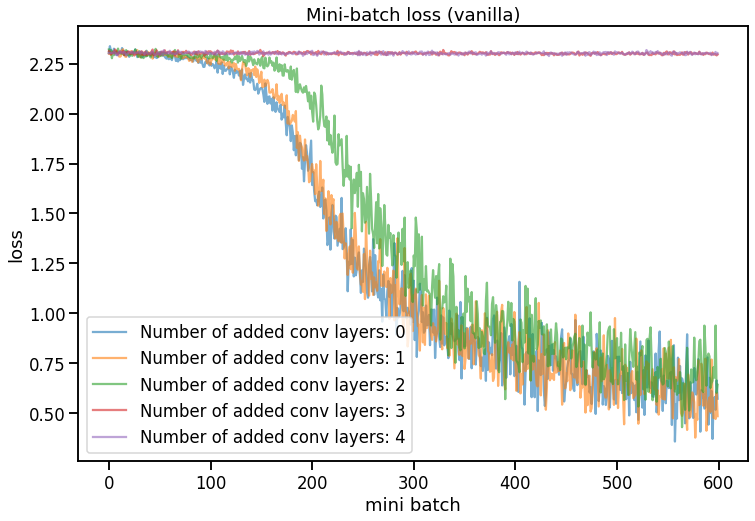

In [ ]:
plt.figure(figsize=(12, 8))
for num_layers in range(5):
  plt.plot(range(len(loss_trajectory_list[num_layers])), 
           loss_trajectory_list[num_layers], 
           label=f"Number of added conv layers: {num_layers}", alpha=0.6)

plt.xlabel("number of mini batches so far")
plt.ylabel("loss")
plt.title("Mini-batch loss (vanilla)")
plt.legend()
plt.show()

**Question**: could you explain why this is the case? Try to think about how the gradient would change with increasing number of layers.

#### Gradnorm curve of Vanilla CNNs with increasing number of layers
Before, we plot the recorded norm of gradients of model parameters at each step.  

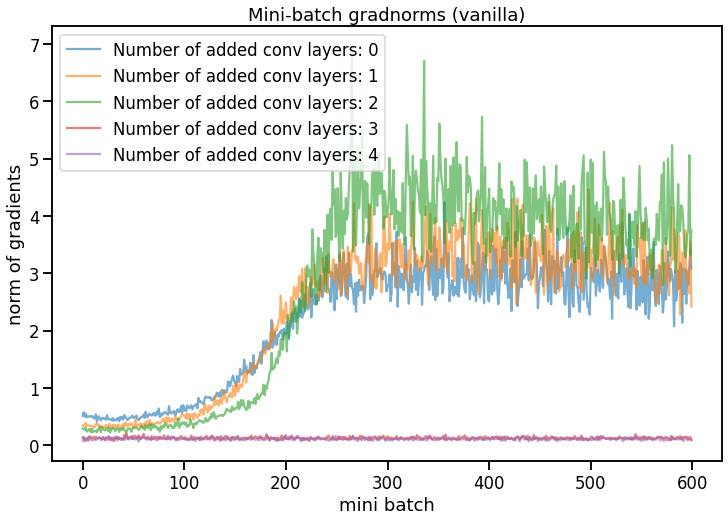

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(len(gradnorm_trajectory_list)):
  plt.plot(range(len(gradnorm_trajectory_list[i])), 
           gradnorm_trajectory_list[i], 
           label=f"Number of added conv layers: {i}", alpha=0.6)

plt.xlabel("number of mini batches so far")
plt.ylabel("norm of gradients")
plt.title("Mini-batch gradnorms (vanilla)")
plt.legend()
plt.show()

### CNN + Residual Connections

Now, let's try to fix the problem with **Residual Connections**.

Residual Connections (or Shortcut/Skip Connections) as the name suggests skips some of the layers in the neural network and feeds the output of one layer as the input to the next layers. 



In this lab, we will use the residual connection illustrated in the image below:



<a title="skip connection" href="https://theaisummer.com/skip-connections/"><img width="512" alt="MnistExamples" src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png"/></a>

Assuming $H(x)$ denotes the true distribution of the input $x$, we have the residual $R(x)$ and 
$$ R(x) = H(x) — x .$$
Since in the above building block, we have an identity connection coming from $x$, the layers are actually trying to learn the residual, $R(x)$. So to summarize, the layers in a traditional network are learning the true output (H(x)), whereas the layers in a residual network are learning the residual (R(x)). Hence, the name: Residual Block.


Let's first define the Residual Block we will use to invert in our CNN.

In [ ]:

class ResidualBlock(nn.Module):
  def __init__(self, in_dim, out_dim, ksize):
      super(ResidualBlock, self).__init__()
      self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_size=ksize, padding="same")
      self.conv2 = nn.Conv2d(in_dim, out_dim, kernel_size=ksize, padding="same")

  def forward(self, x):
    # forward pass
    identity = x 

    out = F.relu(self.conv1(x))
    out = self.conv2(out)
    # combine forward pass and identity through addition

    out += identity

    return F.relu(out) 


The residual-connection-augmented CNN network, named as ResidualNet, will use ResidualBlock as additional layers instead of vanilla conv2d layer.

In [ ]:
class ResidualNet(nn.Module):
  #This defines the structure of the NN.
  def __init__(self, num_add_conv_layers=0):
      super(ResidualNet, self).__init__()
      self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

      # additional conv layers added between conv 1 and conv 2
      # Remember that different with above for the vanilla CNN, each time we will add two conv layers
      self.addconv = torch.nn.ModuleList()
      if num_add_conv_layers != 0:
        for _ in range(num_add_conv_layers):
          self.addconv.append(ResidualBlock(10, 10, ksize=3))

      self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
      self.conv2_drop = nn.Dropout2d()  #Dropout
      self.fc1 = nn.Linear(320, 50)
      self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
      #Convolutional Layer/Pooling Layer/Activation
      x = F.relu(F.max_pool2d(self.conv1(x), 2)) 

      # additional conv
      for add_conv in self.addconv:
        x = F.relu(add_conv(x))

      #Convolutional Layer/Dropout/Pooling Layer/Activation
      x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
      x = x.view(-1, 320)
      #Fully Connected Layer/Activation
      x = F.relu(self.fc1(x))
      x = F.dropout(x, training=self.training) #default: p=0.5
      #Fully Connected Layer/Activation
      x = self.fc2(x)
      return x

In [ ]:
loss_trajectory_list_skip = []
gradnorm_trajectory_list_skip = []
for i in range(5):
  model = ResidualNet(i).to(device)
  loss_function = torch.nn.CrossEntropyLoss().to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
  
  losses, gradnorms = train(model, optimizer, True)

  loss_trajectory_list_skip.append(losses)
  gradnorm_trajectory_list_skip.append(gradnorms)



#### Learning curve of Residual CNNs with increasing number of layers
As we can see from the plot below, SkipNets can learn even with 8 additional convolution layers. Remember that our vanilla CNN stops learning with 3+ additional conv layers.

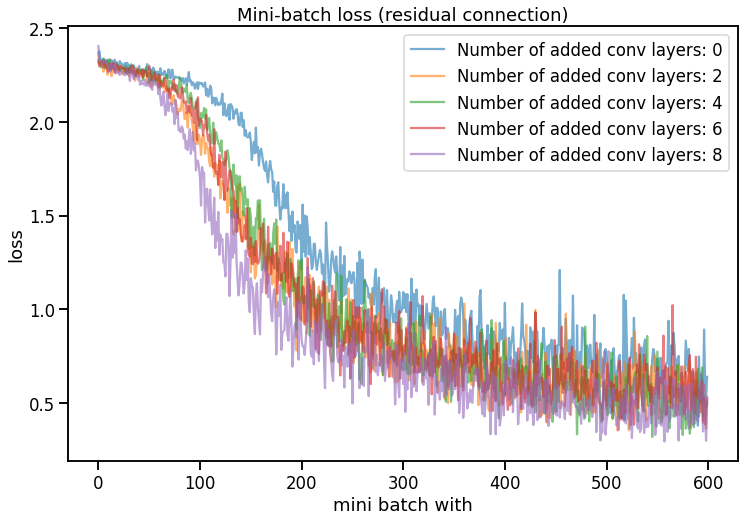

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(len(loss_trajectory_list_skip)):
  plt.plot(range(len(loss_trajectory_list_skip[i])), 
           loss_trajectory_list_skip[i],            
           label=f"Number of added conv layers: {i*2}", 
           alpha=0.6)

plt.xlabel("number of mini batches so far")
plt.ylabel("loss")
plt.title("Mini-batch loss (residual connection)")
plt.legend()
plt.show()


#### Gradnorm curve of Residual CNNs with increasing number of layers
Similarlly, we present the gradient norms of the residualNets. 

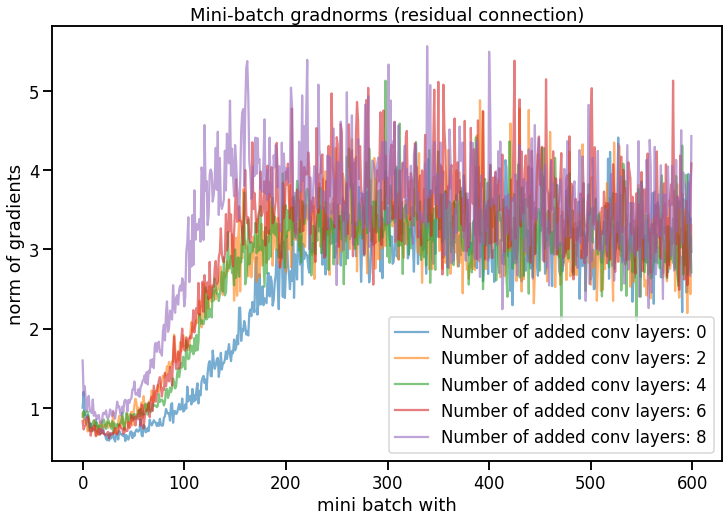

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(len(gradnorm_trajectory_list_skip)):
  plt.plot(range(len(gradnorm_trajectory_list_skip[i])), 
           gradnorm_trajectory_list_skip[i],            
           label=f"Number of added conv layers: {i*2}", 
           alpha=0.6)

plt.xlabel("number of mini batches so far")
plt.ylabel("norm of gradients")
plt.title("Mini-batch gradnorms (residual connection)")
plt.legend()
plt.show()


**Question**: why skip connections are able to help improve the learning dynamics of deep neural networks?

## RNN vs. LSTM



We've learned to use recurrent neural networks (RNNs) to model tasks involving  natural languages or other sequential data. The picture below illustrates the model consisting of RNN units we use for a text classification task.  

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://training.galaxyproject.org/training-material/topics/statistics/images/RNN_n_to_1.png"><img width="512" alt="MnistExamples" src="https://training.galaxyproject.org/training-material/topics/statistics/images/RNN_n_to_1.png"/></a>

Difficulties in learning CNNs appear when we increase its depth. Here, for the RNN based models, we will see similar patterns when we apply it on longer and longer input sequences, i.e, RNNs can suffer from the vanishing/exploring gradients and find hard to learn long distance dependancies.  


We will then show that such issues can be fixed by using LSTM instead of vanilla RNN. 

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://ashutoshtripathicom.files.wordpress.com/2021/06/rnn-vs-lstm.png"><img width="650" alt="MnistExamples" src="https://ashutoshtripathicom.files.wordpress.com/2021/06/rnn-vs-lstm.png"/></a>




### Preparing Data

In this section, we'll be building a deep learning model to detect sentiment (i.e. detect if a sentence is positive or negative) using **PyTorch** and **TorchText**. This will be done on movie reviews, using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

One of the main concepts of **TorchText** is the `Field`. These define how your data should be processed. In our sentiment classification task the data consists of both the raw string of the review and the sentiment, either "pos" or "neg".

The parameters of a `Field` specify how the data should be processed. 

We use the `TEXT` field to define how the review should be processed, and the `LABEL` field to process the sentiment. 

Our `TEXT` field has `tokenize='spacy'` as an argument. This defines that the "tokenization" (the act of splitting the string into discrete "tokens"). If no `tokenize` argument is passed, the default is simply splitting the string on spaces. 

`LABEL` is defined by a `LabelField`, a special subset of the `Field` class specifically used for handling labels. We use `torch.long` as the `dtype` for  the processed labels given our choice of `CrossEntropyLoss()`.

For more on `Fields`, go [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).

We also set the random seeds for reproducibility. 


In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(fix_length=500)
LABEL = data.LabelField(dtype = torch.long)

train_data, _ = datasets.IMDB.splits(TEXT, LABEL)
print(f'Number of training examples: {len(train_data)}')

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 42.0MB/s]


Number of training examples: 25000


In [ ]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 50002
Unique tokens in LABEL vocabulary: 2


In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_iterator, _ = data.BucketIterator.splits(
    (train_data, _), 
    batch_size = BATCH_SIZE,
    device = device)

### Models

In [ ]:
# model with vanilla RNN units  
class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        x = F.dropout(output[-1], training = self.training) #default: p=0.5
        return self.fc(x) 

# model with LSTM units  
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim): 
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)        
        output, (hn, cn) = self.rnn(embedded)
        x = F.dropout(output[-1], training = self.training) #default: p=0.5
        return self.fc(x)

### Training loop

We modify the above defined training loop to accommodate the characteristics of models for sequential data. We will record the loss at each updating step, as well as the norm of gradients for all model parameters.

In [ ]:
def train(model, optimizer, criterion, train_iterator, sentence_len, epoch, verbose=True):
  loss_history = []
  gradnorm_history = []
  model.train()
  for i in range(epoch):
    for batch_idx, batch in enumerate(train_iterator):
        optimizer.zero_grad()
        #truncate sentence to the given length
        input = batch.text[:sentence_len, :]
        output = model(input).squeeze(1)

        loss = criterion(output, batch.label)
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        loss = loss.data.cpu().numpy()
        loss_history.append(loss) 
        # we record the model parameters' gradient norm
        gradnorm_history.append(compute_gradnorm(model))

        #Print out the loss periodically. 
        if verbose and batch_idx % 50 == 0:
            print(f"Train Epoch {i}: [{batch_idx * len(batch)}/{len(train_iterator.dataset)}",
                  f"({100. * batch_idx / len(train_iterator) :.0f}%)]\tLoss: {loss :.6f}")
  return loss_history, gradnorm_history

In [ ]:
# hyperparameters 
input_dim = len(TEXT.vocab)
emb_dim = 50
hidden_dim = 50
out_dim = 2
epochs = 20
lr = 1e-3
sentence_lens = [10, 50, 100, 200, 300]

### Learning curve on loss and grad norms of NNs with vanilla RNN units  

In [ ]:
rnn_loss_trajectory_list = []
rnn_gradnorm_trajectory_list = []
for sen_len in sentence_lens:

  model = RNNModel(input_dim, emb_dim, hidden_dim, out_dim).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss().to(device)

  losses, gradnorms = train(model, optimizer, criterion, train_iterator, sen_len, epochs, False)
  rnn_loss_trajectory_list.append(losses)
  rnn_gradnorm_trajectory_list.append(gradnorms)

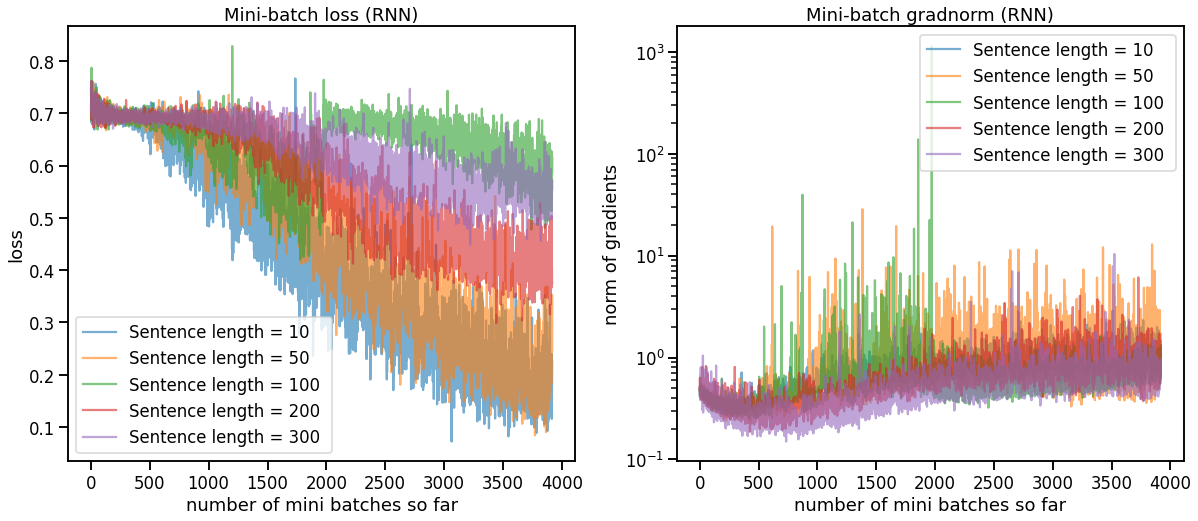

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for l, losses in zip(sentence_lens, rnn_loss_trajectory_list):
  axs[0].plot(range(len(losses)), losses, label=f"Sentence length = {l} ", alpha=0.6)

axs[0].set_xlabel("number of mini batches so far")
axs[0].set_ylabel("loss")
axs[0].set_title("Mini-batch loss (RNN)")
axs[0].legend()


for l, losses in zip(sentence_lens, rnn_gradnorm_trajectory_list):
  axs[1].plot(range(len(losses)), losses, label=f"Sentence length = {l} ", alpha=0.6)

axs[1].set_xlabel("number of mini batches so far")
axs[1].set_ylabel("norm of gradients")
axs[1].set_yscale('log')
axs[1].set_title("Mini-batch gradnorm (RNN)")
axs[1].legend()

plt.show()

### Learning curve on loss and grad norms of NNs with LSTM units  

In [ ]:
lstm_loss_trajectory_list = []
lstm_gradnorm_trajectory_list = []
for sen_len in sentence_lens:

  model = LSTMModel(input_dim, emb_dim, hidden_dim, out_dim).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss().to(device)

  losses, gradnorms = train(model, optimizer, criterion, train_iterator, sen_len, epochs, False)
  lstm_loss_trajectory_list.append(losses)
  lstm_gradnorm_trajectory_list.append(gradnorms)

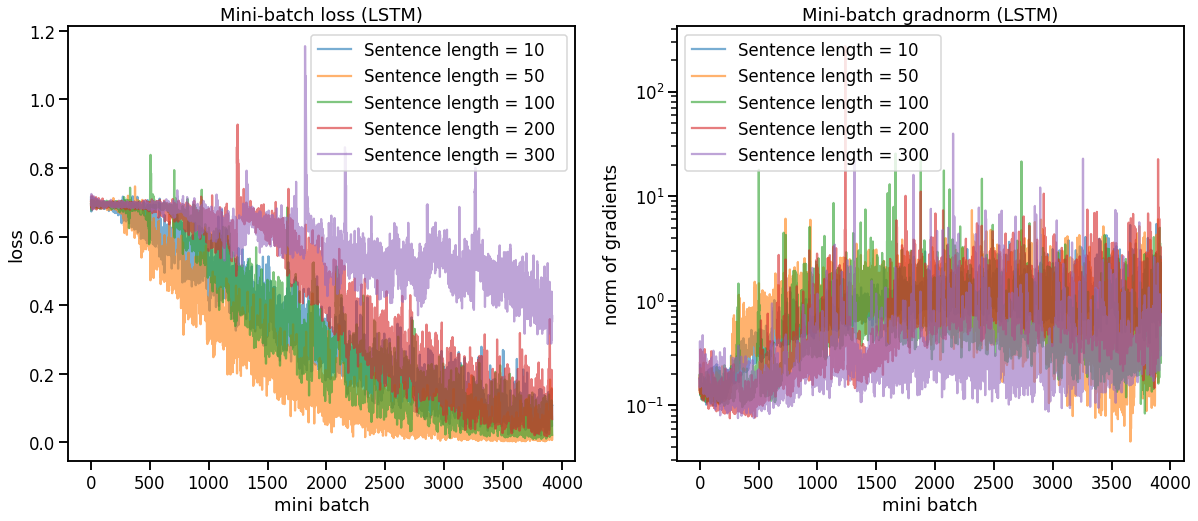

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for l, losses in zip(sentence_lens, lstm_loss_trajectory_list):
  axs[0].plot(range(len(losses)), losses, label=f"Sentence length = {l} ", alpha=0.6)

axs[0].set_xlabel("mini batch")
axs[0].set_ylabel("loss")
axs[0].set_title("Mini-batch loss (LSTM)")
axs[0].legend()


for l, losses in zip(sentence_lens, lstm_gradnorm_trajectory_list):
  axs[1].plot(range(len(losses)), losses, label=f"Sentence length = {l} ", alpha=0.6)

axs[1].set_xlabel("mini batch")
axs[1].set_ylabel("norm of gradients")
axs[1].set_yscale('log')
axs[1].set_title("Mini-batch gradnorm (LSTM)")
axs[1].legend()

plt.show()

### BiLSTM

In [ ]:
# model with bi-directional LSTM units  
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim): 
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)        
        output, (hn, cn) = self.rnn(embedded)
        x = F.dropout(output[-1], training = self.training) #default: p=0.5
        return self.fc(x)

bilstm_loss_trajectory_list = []
bilstm_gradnorm_trajectory_list = []
for sen_len in sentence_lens:

  model = BiLSTMModel(input_dim, emb_dim, hidden_dim, out_dim).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss().to(device)

  losses, gradnorms = train(model, optimizer, criterion, train_iterator, sen_len, epochs, True)
  bilstm_loss_trajectory_list.append(losses)
  bilstm_gradnorm_trajectory_list.append(gradnorms)

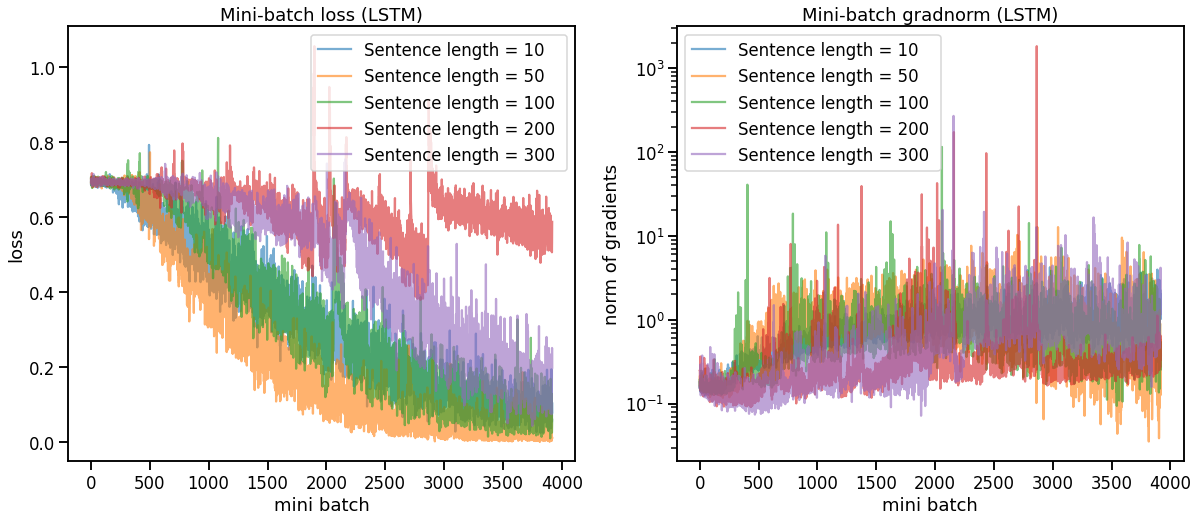

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for l, losses in zip(sentence_lens, bilstm_loss_trajectory_list):
  axs[0].plot(range(len(losses)), losses, label=f"Sentence length = {l} ", alpha=0.6)

axs[0].set_xlabel("mini batch")
axs[0].set_ylabel("loss")
axs[0].set_title("Mini-batch loss (LSTM)")
axs[0].legend()


for l, losses in zip(sentence_lens, bilstm_gradnorm_trajectory_list):
  axs[1].plot(range(len(losses)), losses, label=f"Sentence length = {l} ", alpha=0.6)

axs[1].set_xlabel("mini batch")
axs[1].set_ylabel("norm of gradients")
axs[1].set_yscale('log')
axs[1].set_title("Mini-batch gradnorm (LSTM)")
axs[1].legend()

plt.show()

## Acknowledgement:
this part of the notebook is adopted from
*  https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/04-pytorch-mnist.ipynb.
* https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb#scrollTo=N8eetVP3sPKH